## Breast Cancer Detectioin using Transfer learning

## Importing the libraries

In [88]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.layers import *

from tensorflow.keras.applications import VGG16, ResNet50, MobileNet, MobileNetV2, inception_v3

import warnings
warnings.filterwarnings('ignore')

## Deleting mask images

In [4]:
#Here we are deleting the mask data as we don't need those to train our moodels.

#image_path = '/content/drive/MyDrive/Freelance project/Breast Cancer detection/Breast_cancer/'
#for i in os.listdir(image_path):
 #   for j in os.listdir(os.path.join(image_path, i)):
  #      if 'mask' in j:
   #         os.remove(image_path+ '/'+  i +'/'+ j)

In [5]:
train_path = '/content/drive/MyDrive/Freelance project/Breast Cancer detection/Breastcancer/train'
test_path = '/content/drive/MyDrive/Freelance project/Breast Cancer detection/Breastcancer/test'

## Data visualization

In [6]:
from IPython.core.display import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
data_gen = ImageDataGenerator(rescale = 1.0/255) #Creating a image Data generator object
data = data_gen.flow_from_directory(train_path, # image_path
                                    target_size = (224,224), # setting the image size
                                    batch_size = 32,
                                    class_mode = 'sparse'
                                    )

Found 693 images belonging to 3 classes.


In [7]:
labels= data.class_indices # labels
class_names = list(labels.keys()) #converting it into a python list

In [8]:
class_names

['benign', 'malignant', 'normal']

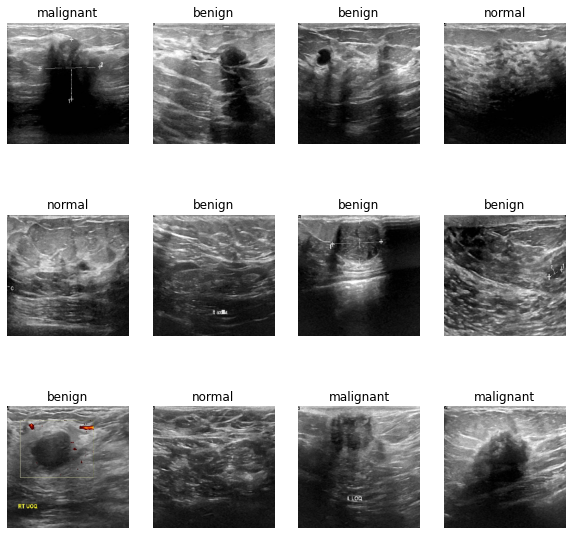

In [9]:
plt.figure(figsize= (10,10))
for i in data:
  images = i[0] # i was an touple of images and label
  labels = i[1]
  for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(images[i])
    plt.title(class_names[int(labels[i])])
    plt.axis('off')
  break

## Data Augmentation

In [10]:
#data augmentation
train_datagen = ImageDataGenerator( rotation_range=10, 
                                    width_shift_range=0.2,
                                    height_shift_range=0.15,
                                    shear_range=0.2,
                                    zoom_range=0.18,
                                    channel_shift_range=0.,
                                    fill_mode='nearest',
                                    cval=0.1,
                                    horizontal_flip=True,
                                    rescale=1.0/255,
                                    )
train_data = train_datagen.flow_from_directory(train_path,
                                               target_size = (224,224),
                                               batch_size = 32,
                                               class_mode = 'sparse')

Found 693 images belonging to 3 classes.


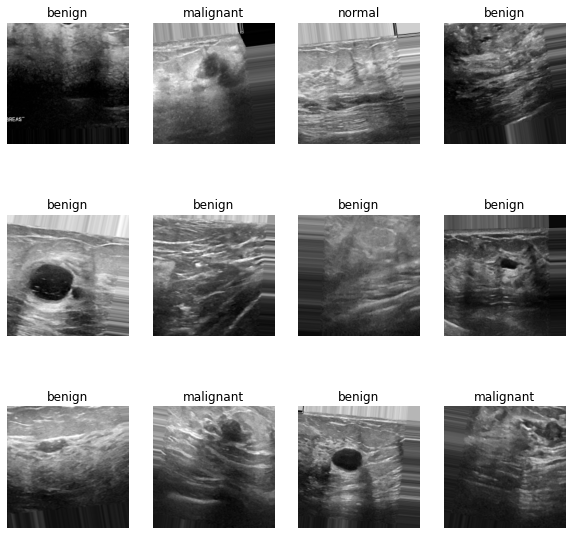

In [11]:
#After augmentation
plt.figure(figsize = (10,10))
for batch in train_data:
  images = batch[0]
  labels = batch[1]
  for  i in range(12):
    ax = plt.subplot(3,4, i+1)
    plt.imshow(images[i])
    plt.title(class_names[int(labels[i])])
    plt.axis('off')

  break

In [12]:
test_data = data_gen.flow_from_directory(test_path,
                                         target_size = (224,224),
                                         batch_size = 32,
                                         class_mode = 'sparse',
                                         )

Found 87 images belonging to 3 classes.


# Transfer Learning 

MobileNet customization

In [13]:
#Initializing the mobilenet architecture
mobilenet_model = tf.keras.applications.MobileNet(
                weights="imagenet",     
                input_shape=(224,224,3),
                include_top=False,
            )


17235968/17225924 [==============================] - 0s 0us/step


In [14]:
mobilenet_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [15]:
# making the all the layer of the mobilenet is untrainable as we don't wnat to train those again. 
for layer in mobilenet_model.layers:
    layer.trainable = False

In [16]:
# Making the mobilenet model into Sequential model and customizing the model
model = Sequential()
model.add(mobilenet_model)
model.add(Flatten())
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(3,activation='softmax'))


    

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 flatten_1 (Flatten)         (None, 50176)             0         
                                                                 
 batch_normalization (BatchN  (None, 50176)            200704    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 512)               25690624  
                                                                 
 dropout (Dropout)           (None, 512)               0

In [18]:

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("./model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='acc',
                          min_delta=0,
                          patience=5,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor='acc',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001)

callbacks_list = [early_stopping,checkpoint,reduce_learningrate]


In [19]:
#Model compilation
model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
             optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
             metrics=['accuracy'])


In [21]:
history = model.fit(train_data, validation_data = test_data, epochs = 20, callbacks=callbacks_list)

Epoch 1/20
22/22 [==============================] - ETA: 0s - loss: 0.7153 - accuracy: 0.7374WARNING:tensorflow:Early stopping conditioned on metric `acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy

Epoch 1: val_accuracy did not improve from 0.65517
22/22 [==============================] - 15s 697ms/step - loss: 0.7153 - accuracy: 0.7374 - val_loss: 0.8917 - val_accuracy: 0.6322 - lr: 0.0010
Epoch 2/20
22/22 [==============================] - ETA: 0s - loss: 0.6363 - accuracy: 0.7662WARNING:tensorflow:Early stopping conditioned on metric `acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy

Epoch 2: val_accuracy did not improve from 0.65517
22/22 [==============================] - 15s 676ms/step - loss: 0.6363 - accuracy: 0.7662 - val_loss: 0.7957 - val_accuracy: 0.6437 - lr: 0.0010
Epoch 3/20
22/22 [==============================] - ETA: 0s - loss: 0.5619 - accuracy: 0.7720WARNING:tensorflow:Early stopping con

In [22]:
loss_test, acc_test = model.evaluate(train_data,verbose=1)
loss_val, acc_val = model.evaluate(test_data
                                   , verbose=1)
print("Train: accuracy = %f  ;  loss_v = %f" % (acc_val, loss_val))
print("Test: accuracy = %f  ;  loss = %f" % (acc_test, loss_test))

3/3 [==============================] - 1s 311ms/step - loss: 0.7781 - accuracy: 0.7471
Train: accuracy = 0.747126  ;  loss_v = 0.778137
Test: accuracy = 0.900433  ;  loss = 0.281204


In [23]:
# function for plotting the model history

def perf_plot(history):
  train_accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  train_loss = history.history['loss']
  val_loss = history.history['val_loss']

  

  fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

  ax[0].set_title('Training Accuracy vs. Epochs')
  ax[0].plot(train_accuracy, color = 'blue', marker = 'o', markerfacecolor = 'red',markersize = 10, label='Train Accuracy')
  ax[0].plot(val_accuracy, color = 'red', marker = 'o', markerfacecolor = 'blue',markersize = 10, label='Validation Accuracy')
  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('Accuracy')
  ax[0].legend(loc='best')

  ax[1].set_title('Training/Validation Loss vs. Epochs')
  ax[1].plot(train_loss, color = 'blue', marker = 'o', markerfacecolor = 'red',markersize = 10, label='Train Loss')
  ax[1].plot(val_loss, color = 'red', marker = 'o', markerfacecolor = 'blue',markersize = 10, label='Validation Loss')
  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('Loss')
  ax[1].legend(loc='best')


  plt.tight_layout()
  plt.show()

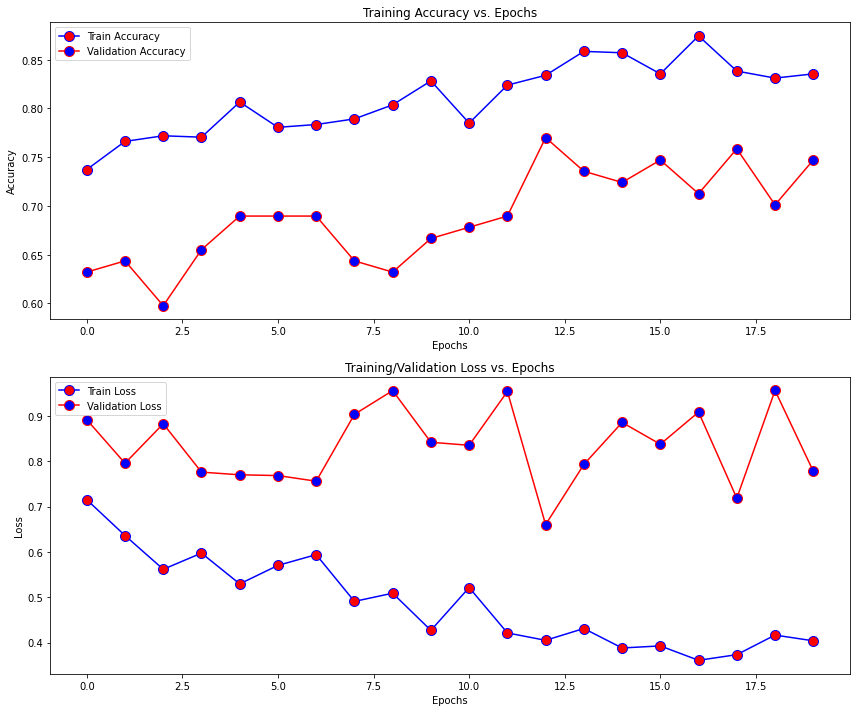

In [24]:
perf_plot(history)

In [31]:
#visualing the test reslult
def test(data):
  plt.figure(figsize= (15,13))
  for i in data:
    images = i[0] # i was an touple of images and label
    labels = i[1]
    for i in range(12):
          ax = plt.subplot(3, 4, i+1)
          image = images[i]
          ex_image = np.expand_dims(image, axis = 0) #expanding the dimension from 3D to 4D
          Actual_label = class_names[int(labels[i])] #converting into numpy from tensor and Actual class label)
          plt.imshow(image)#printing the image
          prediction = model.predict(ex_image) #prediction on the test image
          predicted_label = class_names[np.argmax(prediction)] #Predicted class name
          confidence = round(100 * np.max(prediction), 2) # Confidence on prediction
          plt.title(f"Actual class: {Actual_label}, \n Predicted: {predicted_label}, \n Confidence:, {confidence}")
          plt.axis('off')

    break

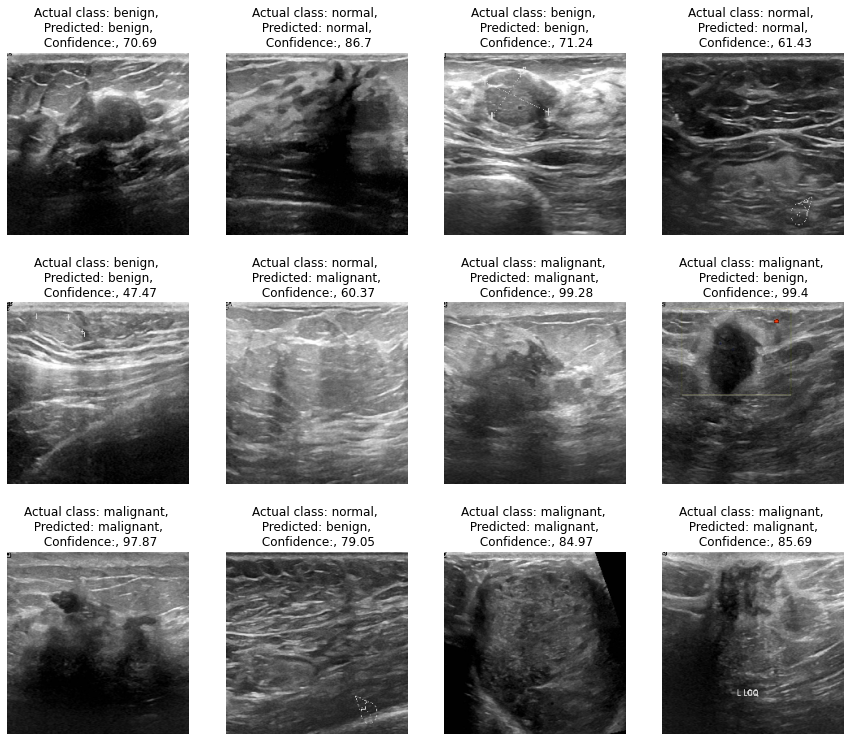

In [32]:
test(test_data)

### MobileNet_V2

In [35]:
#Initializing the mobilenet V2 architecture
mobilenet2_model = tf.keras.applications.MobileNetV2(
                weights="imagenet",     
                input_shape=(224,224,3),
                include_top=False,
            )

In [37]:
mobilenet2_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [38]:
# making the all the layer of the mobilenet_v2 is untrainable as we don't wnat to train those again. 
for layer in mobilenet2_model.layers:
    layer.trainable = False

In [40]:
# Making the mobilenet2 model into Sequential model and customizing the model
model = Sequential()
model.add(mobilenet2_model)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(3,activation='softmax'))


    

In [41]:
#Model compilation
model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
             optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
             metrics=['accuracy'])


In [42]:

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("./mobilenetv2.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='acc',
                          min_delta=0,
                          patience=5,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor='acc',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001)

callbacks_list = [early_stopping,checkpoint,reduce_learningrate]


In [43]:
historty_2 = model.fit(train_data, validation_data = test_data, epochs = 25, callbacks = callbacks_list)

Epoch 1/25
22/22 [==============================] - ETA: 0s - loss: 1.2149 - accuracy: 0.4805WARNING:tensorflow:Early stopping conditioned on metric `acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy

Epoch 1: val_accuracy improved from -inf to 0.56322, saving model to ./mobilenetv2.h5
22/22 [==============================] - 23s 867ms/step - loss: 1.2149 - accuracy: 0.4805 - val_loss: 1.6512 - val_accuracy: 0.5632 - lr: 0.0010
Epoch 2/25
22/22 [==============================] - ETA: 0s - loss: 0.8945 - accuracy: 0.6176WARNING:tensorflow:Early stopping conditioned on metric `acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy

Epoch 2: val_accuracy did not improve from 0.56322
22/22 [==============================] - 15s 688ms/step - loss: 0.8945 - accuracy: 0.6176 - val_loss: 1.1939 - val_accuracy: 0.4828 - lr: 0.0010
Epoch 3/25
22/22 [==============================] - ETA: 0s - loss: 0.8299 - accuracy: 0.6609WA

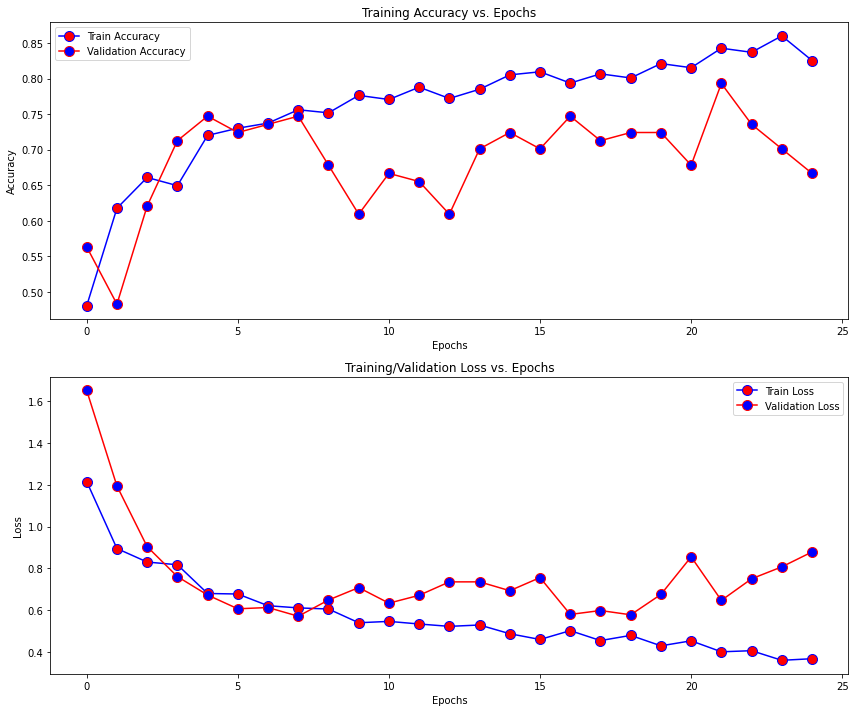

In [44]:
#Visualizing the model training phase of mobilenetv2
perf_plot(historty_2)

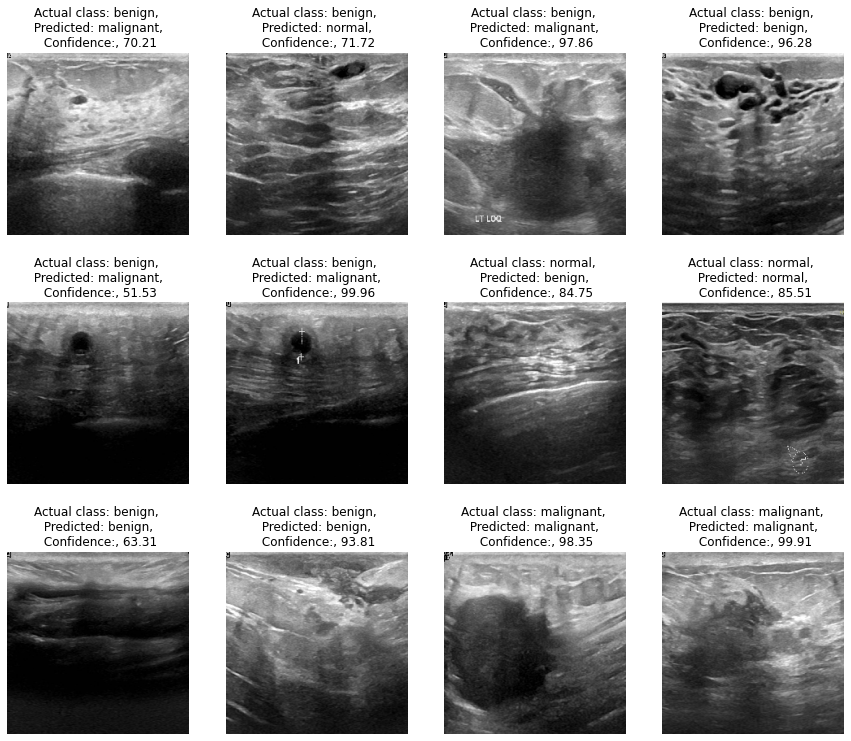

In [45]:
test(test_data)

## Inception_V3

In [91]:
#Initializing the VGG16 architecture
in_model = tf.keras.applications.inception_v3.InceptionV3(
                weights="imagenet",     
                input_shape=(224,224,3),
                include_top = False
                
            )

In [92]:
for layer in in_model.layers:
    layer.trainable = False

In [93]:
in_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 111, 111, 32  864         ['input_14[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_113 (Batch  (None, 111, 111, 32  96         ['conv2d_94[0][0]']              
 Normalization)                 )                                                      

In [95]:
# Making the mobilenet2 model into Sequential model and customizing the model
model = Sequential()
model.add(in_model)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(3,activation='softmax'))


    

In [96]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten_9 (Flatten)         (None, 51200)             0         
                                                                 
 batch_normalization_210 (Ba  (None, 51200)            204800    
 tchNormalization)                                               
                                                                 
 dense_31 (Dense)            (None, 512)               26214912  
                                                                 
 dropout_21 (Dropout)        (None, 512)               0         
                                                                 
 batch_normalization_211 (Ba  (None, 512)              2048      
 tchNormalization)                                   

In [97]:
#Model compilation
model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
             optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
             metrics=['accuracy'])


In [98]:

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("./incep_model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='acc',
                          min_delta=0,
                          patience=5,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor='acc',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001)

callbacks_list = [early_stopping,checkpoint,reduce_learningrate]


In [99]:
historty_3 = model.fit(train_data, validation_data = test_data, epochs = 30, callbacks = callbacks_list)

Epoch 1/30
22/22 [==============================] - ETA: 0s - loss: 1.1495 - accuracy: 0.5224WARNING:tensorflow:Early stopping conditioned on metric `acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy

Epoch 1: val_accuracy improved from -inf to 0.52874, saving model to ./incep_model.h5
22/22 [==============================] - 25s 899ms/step - loss: 1.1495 - accuracy: 0.5224 - val_loss: 1.3666 - val_accuracy: 0.5287 - lr: 0.0010
Epoch 2/30
22/22 [==============================] - ETA: 0s - loss: 0.8588 - accuracy: 0.6479WARNING:tensorflow:Early stopping conditioned on metric `acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy

Epoch 2: val_accuracy improved from 0.52874 to 0.56322, saving model to ./incep_model.h5
22/22 [==============================] - 18s 802ms/step - loss: 0.8588 - accuracy: 0.6479 - val_loss: 1.3710 - val_accuracy: 0.5632 - lr: 0.0010
Epoch 3/30
22/22 [==============================] - ETA: 

In [100]:
loss_test, acc_test = model.evaluate(train_data,verbose=1)
loss_val, acc_val = model.evaluate(test_data
                                   , verbose=1)
print("Train: accuracy = %f  ;  loss_v = %f" % (acc_val, loss_val))
print("Test: accuracy = %f  ;  loss = %f" % (acc_test, loss_test))

3/3 [==============================] - 1s 312ms/step - loss: 0.8361 - accuracy: 0.6897
Train: accuracy = 0.689655  ;  loss_v = 0.836085
Test: accuracy = 0.860029  ;  loss = 0.344993


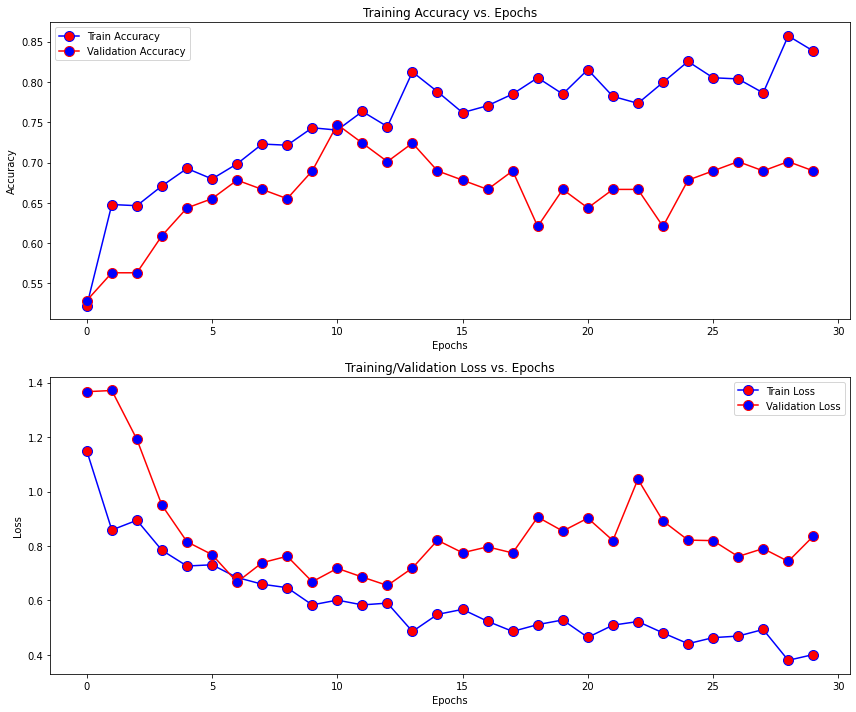

In [101]:
perf_plot(historty_3)

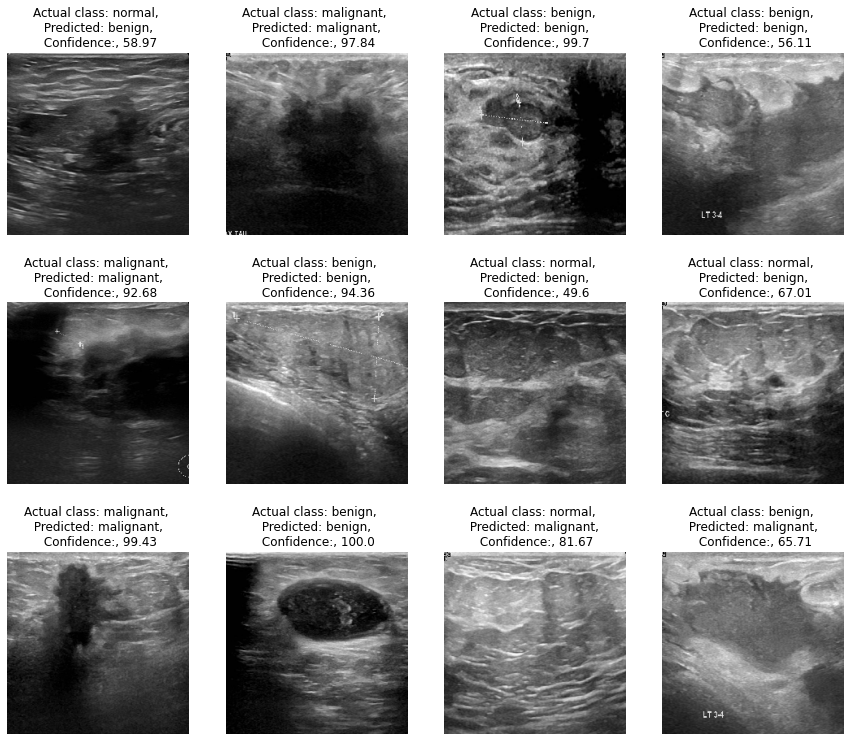

In [103]:
test(test_data)